In [3]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
from collections import defaultdict
from torch.utils.data import random_split
import re

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikegen

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.nn.functional as F

import audio_import_giantstep as aig
import audio_import_ballroom as aib
import audio_import_syn as ais
import time
import beepy
import tonic


In [3]:
# pickle datasets

def save_preprocessed_data(loader: DataLoader, filename):
    with open(filename, 'wb') as f:
        pickle.dump(loader.dataset, f)
        
# Assuming `data, labels, val_bpm` are your preprocessed data
sum_loader = DataLoader(ConcatDataset([train_set_giant, val_set_giant]), batch_size=batch_size, shuffle=True)
save_preprocessed_data(sum_loader, 'preprocessed_data_giant.pkl')

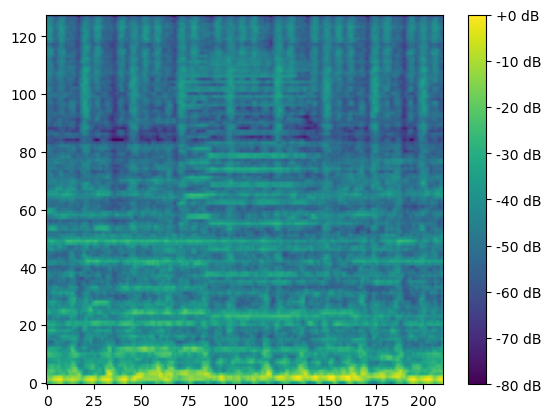

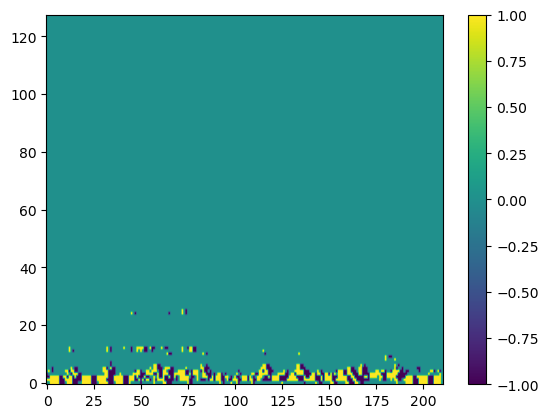

In [4]:
# Loading the datasets from disk
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

loaded_dataset = load_preprocessed_data('preprocessed_data_giant.pkl')

ground_truth_max = 200
ground_truth_min = 80
MAX_OCCURRENCES = 1500


# Step 1: Filter data based on ground truth range
filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/20)]

label_dict = defaultdict(list)
for item in filtered_dataset:
    label = item[1].item()  # .item() ensures we're working with Python int, not a tensor
    label_dict[label].append(item)

# Step 3: Limit each label's items to max 100
limited_items = []
for label, items in label_dict.items():
    limited_items_for_label = items[:MAX_OCCURRENCES]
    limited_items.extend(limited_items_for_label)

# Step 4: Construct the final dataset (this will be a list, not a ConcatDataset)
filtered_dataset = limited_items

###############################################

train_data_ratio = 0.9
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_loader.dataset[0][0].squeeze(0).shape


example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
single_mel_db = librosa.power_to_db(single_mel, ref=np.max)
# min max normalize single_mel_db

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()


# Define a threshold for change detection
threshold = 0.0024  # This value may need tuning

# Find the changes from one frame to the next
diffs = np.diff(single_mel, axis=1)

# Get event coordinates where change exceeds threshold
event_coords = np.argwhere(np.abs(diffs) >= threshold)

# Build events with [x, y, time, polarity] structure
events = []
for coord in event_coords:
    y, x = coord  # flip coordinates to match your description
    polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
    events.append([x, y, x, polarity])  # Using x as a simple stand-in for time

events = np.array(events)

# If you wish to visualize the events somehow:
# This is a simplification; you'd likely want a better visualization
event_img = np.zeros_like(single_mel)
for event in events:
    event_img[event[1], event[0]] = event[3]  # Polarities as pixel values

plt.imshow(event_img, origin='lower', aspect='auto')
plt.colorbar()
plt.show()


# Assume `mel` is your list of Mel spectrograms and `groundtruth` is your list of ground truth labels
assert len(mel) == len(groundtruth), "The lists must be of the same length"

# Pair each Mel spectrogram with its corresponding ground truth label
paired_data = list(zip(mel, groundtruth))

# Sort the paired data based on the ground truth labels
sorted_data = sorted(paired_data, key=lambda x: x[1])

# Separate the sorted pairs back into two lists
sorted_mel, sorted_groundtruth = zip(*sorted_data)

# Now you can use `sorted_mel` and `sorted_groundtruth` in place of `mel` and `groundtruth` in your code

torch.Size([2, 100, 211])


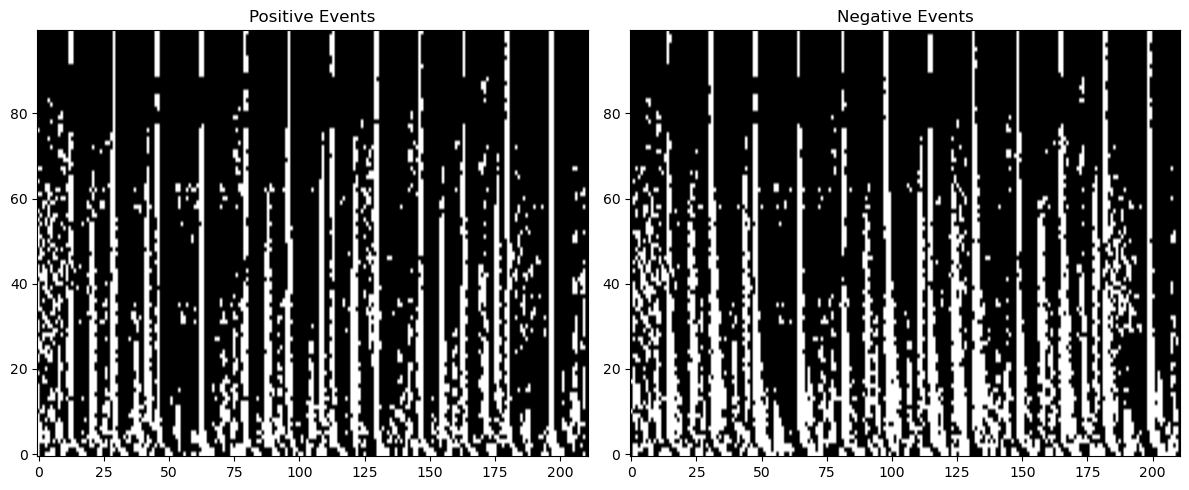

In [5]:
def transform_mel(single_mel, threshold=0.0025):
    threshold = 5 * 10**-6
    frequency_cutoff = 100
    single_mel = single_mel[:frequency_cutoff]    
    diffs = np.diff(single_mel, axis=1)
    event_coords = np.argwhere(np.abs(diffs) >= threshold)

    positive_event_img = np.zeros_like(single_mel)
    negative_event_img = np.zeros_like(single_mel)

    for coord in event_coords:
        y, x = coord
        polarity = 1 if diffs[coord[0], coord[1]] > 0 else -1
        if polarity == 1:
            positive_event_img[y, x] = 1
        else:
            negative_event_img[y, x] = 1

    return positive_event_img, negative_event_img

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        positive, negative = transform_mel(mel.squeeze(0))
        transformed_mel = np.stack([positive, negative], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa

    
# Apply the transformation
transformed_train_dataset = TransformedDataset(train_loader.dataset)
transformed_val_dataset = TransformedDataset(val_loader.dataset)

# Create DataLoaders
batch_size_new = 256
train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape

def plot_mel_channels(mel_tensor):
    # Ensure the tensor is on the CPU for visualization
    mel_tensor = mel_tensor.cpu()
    
    # Extract positive and negative events
    positive_events = mel_tensor[0]
    negative_events = mel_tensor[1]

    fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
    
    axarr[0].imshow(positive_events, origin='lower', aspect='auto', cmap='gray')
    axarr[0].set_title('Positive Events')
    
    axarr[1].imshow(negative_events, origin='lower', aspect='auto', cmap='gray')
    axarr[1].set_title('Negative Events')
    
    plt.tight_layout()
    plt.show()

# Visualization example:
plot_mel_channels(mel[0])  # visualize the first sample from the batch


In [73]:
class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Compute the size after conv and pooling layers to be fed into LSTM
        _, c, h, w = self.compute_intermediate_size(input_shape)
        self.lstm_size = h * c  # new lstm_size
        self.lstm = nn.LSTM(input_size=self.lstm_size, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 128)  # LSTM hidden size to 128
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Reshape data for LSTM
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, width, height * channels)  # Reshaped here
        
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the last output of LSTM
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def compute_intermediate_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        return x.shape



def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()




model = BPMEstimator(input_shape)
print(input_shape)

num_classes = ground_truth_max-ground_truth_min+1

weights_matrix = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    for j in range(num_classes):
        weights_matrix[i, j] = abs((i + ground_truth_min) - (j + ground_truth_min))

# Normalize weights to be between 0 and 1
weights_matrix = 1 - (weights_matrix / weights_matrix.max())


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = weighted_cross_entropy
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

torch.Size([128, 211])


In [ ]:
## 2 channel SNN

class SpikingNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpikingNet, self).__init__()

        self.surr_grad = surrogate.FastSigmoid.apply

        # First convolutional layer
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2)
        self.lif1 = snn.Leaky(beta=0.2)

        # Pooling
        self.pool = nn.AvgPool2d(2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.lif2 = snn.Leaky(beta=0.2)

        # Fully connected layer
        self.fc1_size = 64 * (input_shape[1] // 4) * (input_shape[2] // 4)
        self.fc1 = nn.Linear(self.fc1_size, 1000)
        self.lif3 = snn.Leaky(beta=0.2)

        # Output layer
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x, mem=None):
        if mem is None:
            mem = {
                'conv1': torch.zeros(x.size(0), 32, x.size(2), x.size(3), device=x.device),
                'conv2': torch.zeros(x.size(0), 64, x.size(2)//2, x.size(3)//2, device=x.device),
                'fc1': torch.zeros(x.size(0), 1000, device=x.device)
            }

        # First convolutional layer
        x, mem['conv1'] = self.lif1(self.conv1(x), mem['conv1'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Second convolutional layer
        x, mem['conv2'] = self.lif2(self.conv2(x), mem['conv2'])
        x = self.surr_grad(x)
        x = self.pool(x)

        # Flatten for the fully connected layer
        x = x.view(-1, self.fc1_size)

        # Fully connected layer
        x, mem['fc1'] = self.lif3(self.fc1(x), mem['fc1'])
        x = self.surr_grad(x)

        # Output layer
        x = self.fc2(x)
        
        return x, mem

# Define your SNN model
print(num_classes)

def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()




num_classes = ground_truth_max-ground_truth_min+1


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
#criterion = weighted_cross_entropy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikingNet(input_shape, num_classes).to(device)

# Define loss function and optimizer
#criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)



121


In [ ]:
# # Training parameters
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

early_stopping = EarlyStopping(patience=8)
#train_loader = DataLoader(train_loader.dataset, batch_size=200, shuffle=True, drop_last=True)
num_batches = len(train_loader)

start_time_all = time.time()

num_epochs = 30
time_steps = 3

epoch_losses = []
training_accuracies = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    epoch_loss = 0
    correct = 0
    total = 0
    model.train()

    for i, (inputs, labels, _) in enumerate(train_loader):
        batch_start_time = time.time()
        
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        optimizer.zero_grad()

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)
        
        loss = criterion(outputs, target_zero_indexed)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        batch_duration = time.time() - batch_start_time
        estimated_remaining_time = batch_duration * (num_batches - (i + 1))
        
        # Display the current loss and estimated remaining time for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{num_batches}, Loss: {loss.item():.4f}, Est. Remaining Time: {estimated_remaining_time:.2f} secs", end='\r')
        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * num_epochs
    remaining_time = (num_epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total
    training_accuracies.append(accuracy)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    
    beepy.beep(sound=1)  # 1 for 'coin'    
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{num_epochs} epochs took {end_time/60.0:.2f} mins")


Epoch 1/5, Batch 52/52, Loss: 0.0281, Est. Remaining Time: 0.00 secsss
Epoch 1/5, Training Loss: 0.0159, Accuracy: 99.88%, took 1228.43 seconds
Estimated Total Time: 102.37 mins, Remaining Time: 81.90 mins


KeyboardInterrupt: 

In [7]:
# Set the model to evaluation mode
model.eval()

# Keep track of the total loss
total_loss = 0.0
total_corrects = 0

# No need to compute gradients during validation
with torch.no_grad():
    for i, (inputs, labels, _) in enumerate(val_loader):  # Assuming you have a val_loader for validation data
        inputs, labels = inputs.to(device), labels.to(device)
        target_zero_indexed = labels - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(inputs, mem)

        loss = criterion(outputs, target_zero_indexed)
        total_loss += loss.item()

        # Assuming this is a classification task and you want to calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_corrects += (predicted == target_zero_indexed).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = total_corrects / len(val_loader.dataset)

    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Validation Loss: 0.1648, Accuracy: 0.9721


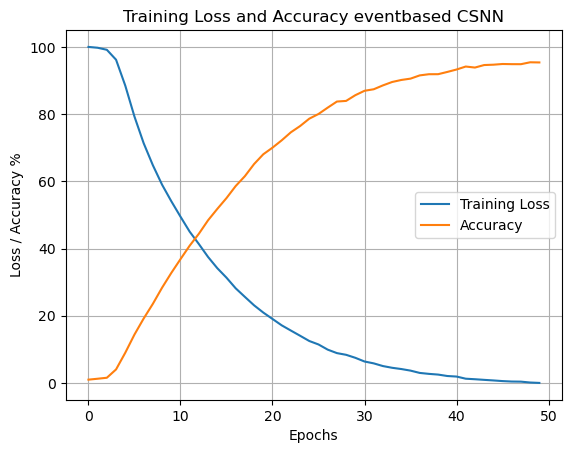

In [30]:
def min_max_normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

norm1 = min_max_normalize(np.array(epoch_losses))* 100

# If the accuracy is between 0 and 1, multiply by 100. 
# If it's already in the range 0-100, you don't need to multiply.
norm2 = np.array(training_accuracies)  # Adjust as per your data

plt.plot(norm1, label="Training Loss")
plt.plot(norm2, label="Accuracy")
plt.grid(True)
plt.title("Training Loss and Accuracy eventbased CSNN")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy %")
plt.legend()
plt.show()

In [ ]:
# second training
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets, _  in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data).squeeze()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

TypeError: to() received an invalid combination of arguments - got (CurrentDeviceProxy), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)


In [45]:
def correct_octave_error(predictions, true_values):
        # If the inputs are not iterable (lists or arrays), wrap them in a list.
    corrected_predictions = []
        
    for pred, true in zip(predictions, true_values):
        half_pred = pred / 2
        double_pred = pred * 2
        
        error_original = abs(true - pred)
        error_half = abs(true - half_pred)
        error_double = abs(true - double_pred)
        
        if error_half < error_original:
            corrected_predictions.append(half_pred)
        elif error_double < error_original:
            corrected_predictions.append(double_pred)
        else:
            corrected_predictions.append(pred)
            
    return np.array(corrected_predictions)

def is_SNN(model):
    for name, module in model.named_modules():
        if isinstance(module, snn.Leaky):
            return True
    return False

model_type = 'SCNN' if is_SNN(model) else "CNN"


# model.eval()
# data, targets, librosa_bpm = next(iter(train_loader))
# # outputs, _ = model(data)
# outputs = model(data)
# predictions = torch.argmax(outputs, dim=1) + ground_truth_min
# #predictions = outputs

# fig, axarr = plt.subplots(3, 3, figsize=(15, 15))  # create a 3x3 grid of plots

# for i in range(3):
#     for j in range(3):
#         idx = i * 3 + j  # get the current index in the batch
        
#         # plot mel spectrogram
#         mel_data = data[idx].squeeze(0)
#         axarr[i, j].imshow(librosa.power_to_db(mel_data, ref=np.max), origin='lower', aspect='auto')
#         #corrected_pred = correct_octave_error([int(predictions[idx])], [int(targets[idx])])
#         axarr[i, j].set_title(f"Librosa BPM: {int(librosa_bpm[idx])} Pred: {int(predictions[idx])},  True: {int(targets[idx])}")
#         axarr[i, j].axis('off')  # hide axis

# plt.tight_layout()
# plt.show()


# No need to compute gradients during validation
# with torch.no_grad():
#     for i, (inputs, labels, _) in enumerate(val_loader):  # Assuming you have a val_loader for validation data
#         inputs, labels = inputs.to(device), labels.to(device)
#         target_zero_indexed = labels - ground_truth_min

#         mem = None
#         for step in range(time_steps):
#             outputs, mem = model(inputs, mem)

#         loss = criterion(outputs, target_zero_indexed)
#         total_loss += loss.item()

#         # Assuming this is a classification task and you want to calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         total_corrects += (predicted == target_zero_indexed).sum().item()

#     avg_loss = total_loss / len(val_loader)
#     accuracy = total_corrects / len(val_loader.dataset)

#     print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    


# Set model to evaluation mode
model.eval()

all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates

#val_syn_loader = DataLoader(val_set_syn, batch_size=128, shuffle=True, drop_last=False)

# # No gradient is needed during evaluation/inference
# cnt = 0
# #val_loader = DataLoader(transformed_val_dataset, batch_size=128, shuffle=True) # bigger batch size causes kernel crash
# with torch.no_grad():
#     for data, target, librosa_bpm in val_loader:
#         # outputs, _ = model(data)
#         outputs = model(data)
#         predictions = torch.argmax(outputs, dim=1) + ground_truth_min
#         all_predictions.extend(predictions.cpu().numpy()) 
#         all_true_labels.extend(target.cpu().numpy())
#         librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())

cnt = 0 

with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        data = data.to(device)
        target_zero_indexed = target.to(device) - ground_truth_min

        mem = None
        for step in range(time_steps):
            outputs, mem = model(data, mem)

        predictions = torch.argmax(outputs, dim=1) + ground_truth_min
        confidences = torch.max(torch.softmax(outputs, dim=1), dim=1)[0].cpu().numpy()
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(target.cpu().numpy())
        all_confidences.extend(confidences)
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

# Korrigiere die Vorhersagen für das Modell und Librosa
all_predictions_corrected = correct_octave_error(all_predictions, all_true_labels)
librosa_bpm_estimates_corrected = correct_octave_error(librosa_bpm_estimates, all_true_labels)

In [46]:


def visualize_based_on_threshold(threshold=0.5, tolerance=1.0):
    # Clear previous plots
    clear_output(wait=True)
    
    # Filter based on confidence threshold
    
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
    correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
    correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
    accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
    print(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
    print(f"cnt  {len(filtered_predictions)}/{len(all_true_labels)}")
    # Update your scatter plot or any other visualizations using high_confidence_indices
    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_labels[high_confidence_indices], all_predictions[high_confidence_indices], color='red', alpha=0.3)
    plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
    plt.axhline(y=0, color='k', linestyle='--')
    plt.title(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {filtered_accuracy:.2f}%\n Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%\n confidence threshold: {threshold}\n after {len(epoch_losses)} epochs")
    plt.xlabel('True Values')
    plt.grid(True)
    plt.legend()
    

    plt.show()
       


# Define and display slider
threshold_slider = widgets.FloatSlider(value=0.5, min=0, max=0.99, step=0.01, description='Confidence Threshold:')
tolerance_slider = widgets.IntSlider(value=1, min=1, max=30, step=1, description='Tolerance:')
widgets.interactive(visualize_based_on_threshold, threshold=threshold_slider, tolerance=tolerance_slider)


interactive(children=(FloatSlider(value=0.5, description='Confidence Threshold:', max=0.99, step=0.01), IntSli…

In [ ]:

# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))
model_corrected_mae = np.mean(np.abs(all_true_labels - all_predictions_corrected))

# Plot Mean Absolute Errors
model_label = f'Model ({model_type})'
labels = ['Librosa', model_label]
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()